In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library.standard_gates import HGate, XGate
from qiskit.visualization import circuit_drawer
import matplotlib.pyplot as plt


 Number of nodes in the circle

In [2]:
size_circle = 2 

Quantum Functions

In [3]:
def prepare_minus(qc, x):
    qc.append(XGate(), [x])
    qc.append(HGate(), [x])

def diffuser_oracle(qc, aux, x):
    qc.cx(aux, x)

def zero_diffuser(qc, aux, x):
    prepare_minus(qc, aux)
    diffuser_oracle(qc, aux, x)
    qc.append(XGate(), [aux])  # Resetting the auxiliary qubit to |0>
    qc.append(XGate(), [aux])  # Applying X again to ensure the qubit is correctly reset


W Operator Functions

In [4]:
def W_iteration_circle(qc, i, vertices, adjacent_vertices, aux):
    prob = [0, 0, 0, 0]
    prob[(i + 1) % 4] = 0.5
    prob[(i - 1) % 4] = 0.5
    print(f'State={i}, prob vec ={prob}')
    # Applying X gate to prepare the control condition
    qc.x(vertices)  
    qc.cx(vertices, adjacent_vertices)
     # Applying X gate again to revert to original state
    qc.x(vertices) 

    zero_diffuser(qc, aux, adjacent_vertices)

def W_operator_circle(qc, vertices, adjacent_vertices):
    aux = QuantumRegister(1, 'aux')
    qc.add_register(aux)
    for i in range(2 ** size_circle):
        W_iteration_circle(qc, i, vertices, adjacent_vertices, aux[0])


Edge Oracle and Bitwise Swap

In [5]:
def edge_oracle(qc, res, vertices, adjacent_vertices):
    for i in range(size_circle):
        qc.cx(vertices[i], adjacent_vertices[i])
        qc.x(adjacent_vertices[i])
    qc.ccx(vertices[0], vertices[1], res)
    for i in range(size_circle):
        qc.x(adjacent_vertices[i])

def bitwise_swap(qc, x, y):
    for i in range(len(x)):
        qc.swap(x[i], y[i])


S Operator and Main Function

In [7]:
def S_operator(qc, vertices, adjacent_vertices):
    res = QuantumRegister(1, 'res')
    qc.add_register(res)
    edge_oracle(qc, res[0], vertices, adjacent_vertices)
    qc.x(res)
    qc.ccx(res[0], vertices[0], adjacent_vertices[0])
    qc.ccx(res[0], vertices[1], adjacent_vertices[1])
    qc.x(res)  # Resetting the auxiliary qubit to |0>
    qc.append(XGate(), [res[0]])  # Applying X again to ensure the qubit is correctly reset

def main_circle():
    vertices = QuantumRegister(size_circle, 'vertices')
    adjacent_vertices = QuantumRegister(size_circle, 'adjacent_vertices')
    c = ClassicalRegister(size_circle, 'c')  # Classical register for measurement
    qc = QuantumCircuit(vertices, adjacent_vertices, c)

    qc.h(vertices)
    W_operator_circle(qc, vertices, adjacent_vertices)
    S_operator(qc, vertices, adjacent_vertices)

    qc.measure(vertices, c)  # Measure vertices to classical register c

    return qc


Printing the Quantum Circuit

In [8]:
qcirc_circle = main_circle()
print(qcirc_circle)

State=0, prob vec =[0, 0.5, 0, 0.5]
State=1, prob vec =[0.5, 0, 0.5, 0]
State=2, prob vec =[0, 0.5, 0, 0.5]
State=3, prob vec =[0.5, 0, 0.5, 0]
                     ┌───┐┌───┐     ┌───┐┌───┐          ┌───┐┌───┐          »
         vertices_0: ┤ H ├┤ X ├──■──┤ X ├┤ X ├───────■──┤ X ├┤ X ├──────────»
                     ├───┤├───┤  │  └───┘├───┤┌───┐  │  └───┘├───┤┌───┐     »
         vertices_1: ┤ H ├┤ X ├──┼────■──┤ X ├┤ X ├──┼────■──┤ X ├┤ X ├─────»
                     └───┘└───┘┌─┴─┐  │  ├───┤└───┘┌─┴─┐  │  └───┘└───┘┌───┐»
adjacent_vertices_0: ──────────┤ X ├──┼──┤ X ├─────┤ X ├──┼────────────┤ X ├»
                               └───┘┌─┴─┐└─┬─┘┌───┐└───┘┌─┴─┐          └─┬─┘»
adjacent_vertices_1: ───────────────┤ X ├──┼──┤ X ├─────┤ X ├────────────┼──»
                     ┌───┐┌───┐     └───┘  │  └─┬─┘┌───┐├───┤┌───┐┌───┐  │  »
                aux: ┤ X ├┤ H ├────────────■────■──┤ X ├┤ X ├┤ X ├┤ H ├──■──»
                     └───┘└───┘                    └───┘└───┘└───┘└───┘     

Display the Plot

c:\Users\max_h\anaconda3\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


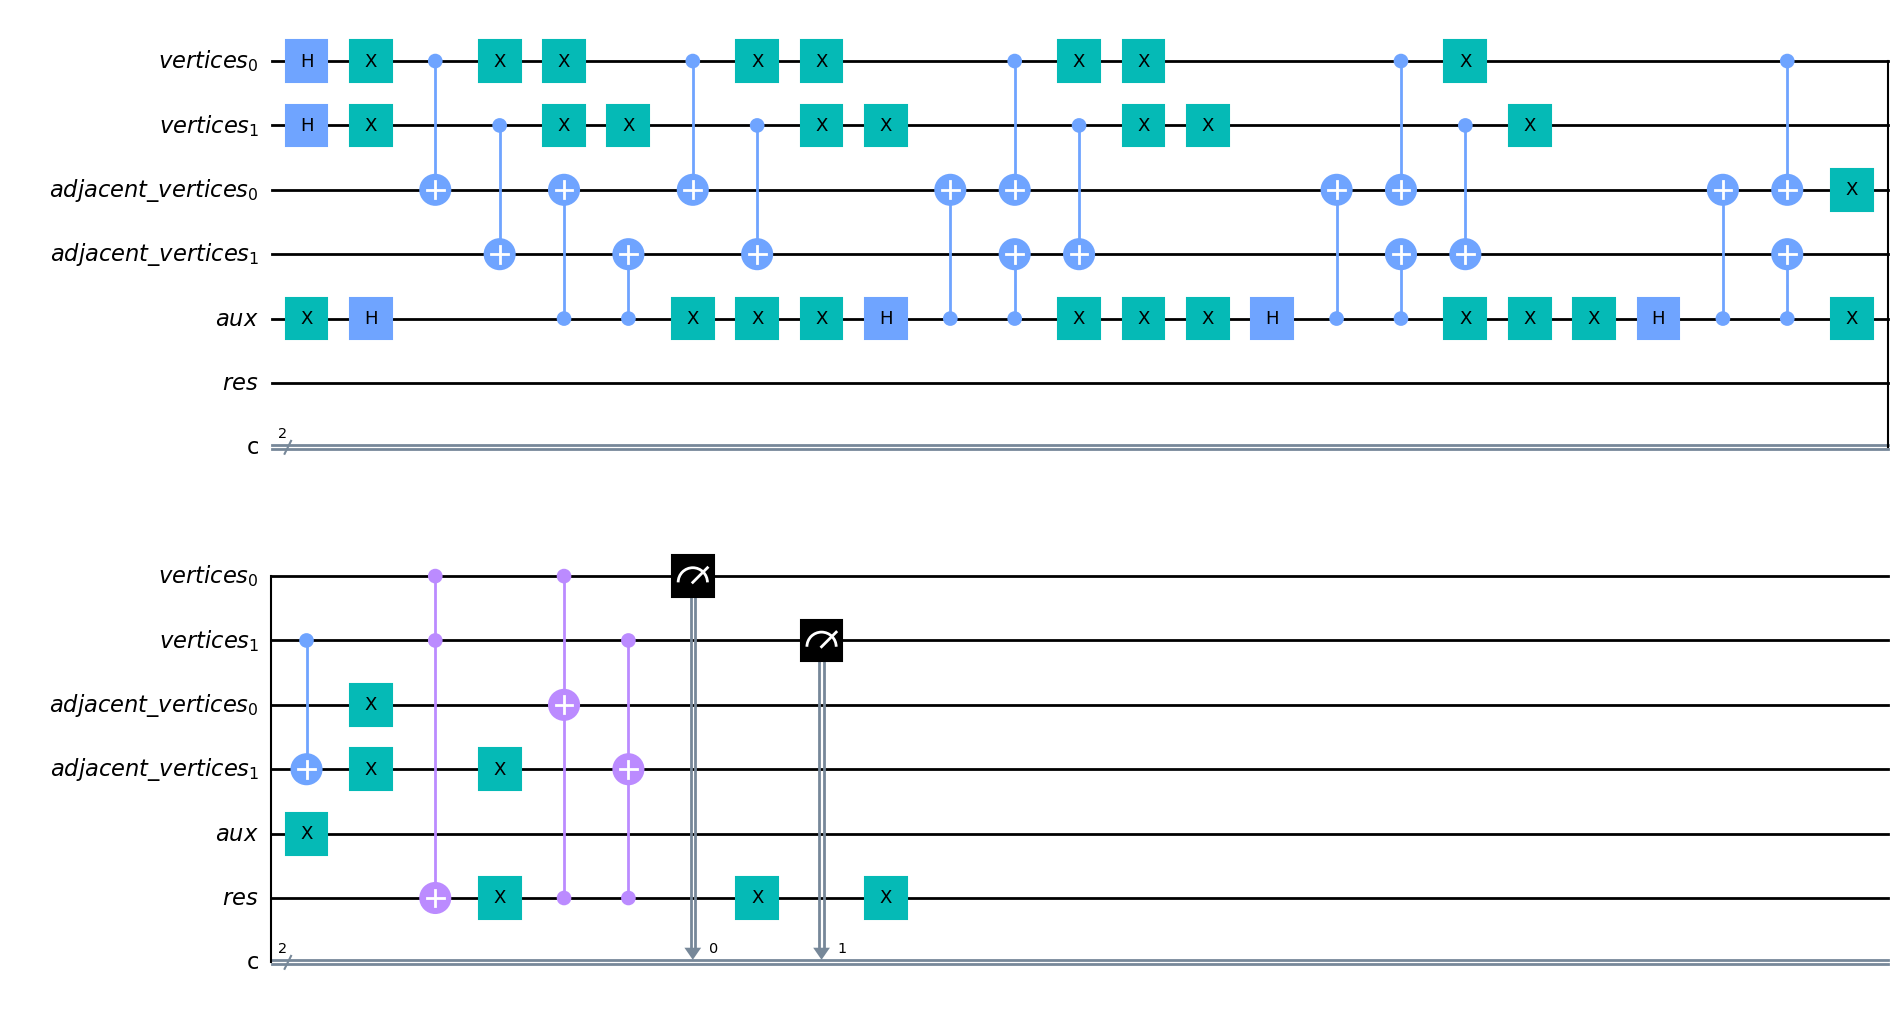

In [9]:
qcirc_circle.draw('mpl')